### Exemplo de resolução referentes as questões 1-3 do projeto final da disciplina de ciência de dados

* Esse é apenas um exemplo de como resolver a atividade, os intervalos nos quais foram variados os parâmetros foram escolhidos arbitrariamente e não há um intervalo certo nem errado. Devido a forma como os dados são divididos os resultados dos modelos podem variar!!!

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

sns.set()

#### Leitura dos dados

In [2]:
wine = pd.read_csv('../data/winequality-red.csv')
target = 'quality'
print(wine.shape)
wine.head()

(1599, 12)


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

### 1. Pré-processamento

In [3]:
#busca por valores nulos
wine.isna().sum(axis=0)

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

* Não temos valores nulos na tabela =)

In [4]:
#busca por variaveis categoricas
wine.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

* Não temos atributos categóricos, logo não precisamos realizar o one-hot-encoding

In [5]:
#verificação do target
wine[target].unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

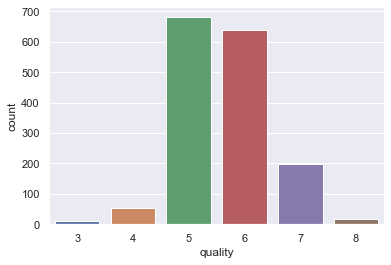

In [6]:
#frequencia da variável quality
sns.countplot(x=target, data=wine)
plt.show()

**Trecho da descrição do dataset no kaggle**: "What might be an interesting thing to do, is aside from using regression modelling, is to set an arbitrary cutoff for your dependent variable (wine quality) at e.g. 7 or higher getting classified as 'good/1' and the remainder as 'not good/0'."

In [7]:
#binarização dos dados considerando qualidades maiores que 7 como 1 e menores como zero
wine_b = wine.copy()
wine_b[target] = np.where((wine_b[target]) >= 7, 1, 0)

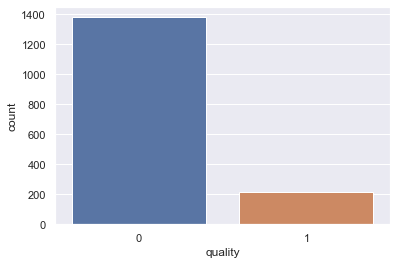

In [8]:
#distribuição depois da binarização
sns.countplot(x=target, data=wine_b);

* Não era necessário binarizar, apenas fiz isso pela sugestão na descrição do kaggle.

In [9]:
#separação em x e y
X = wine_b.loc[:, wine_b.columns != target]
y = wine_b[target]

print(X.shape, y.shape)
X.head()

(1599, 11) (1599,)


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  
0      9.4  
1      9.8  
2      9.8  
3      9.8  
4      9.4

In [10]:
#train/test split
x_train, x_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), random_state=1, test_size=0.2)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1279, 11) (320, 11) (1279,) (320,)


### 2- Classificação

#### KNN com validação cruzada

In [11]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

results = {k: [] for k in range(1, 21)}

for train_index, val_index in skf.split(x_train, y_train):
    
    #separação do conjunto de treinamento e validação
    x_cv_train, x_cv_val = x_train[train_index], x_train[val_index]
    y_cv_train, y_cv_val = y_train[train_index], y_train[val_index]
    
    #aplicando padronização
    scaler = StandardScaler()
    scaler.fit(x_cv_train)
    x_cv_train_std = scaler.transform(x_cv_train)
    x_cv_val_std = scaler.transform(x_cv_val)
    
    #testando os difentes valores possiveis para k
    for k in range(1, 21):
        
        clf = KNeighborsClassifier(n_neighbors=k)
        clf.fit(x_cv_train_std, y_cv_train)
        y_cv_pred = clf.predict(x_cv_val_std)
        score = accuracy_score(y_cv_val, y_cv_pred)
        results[k].append(score)

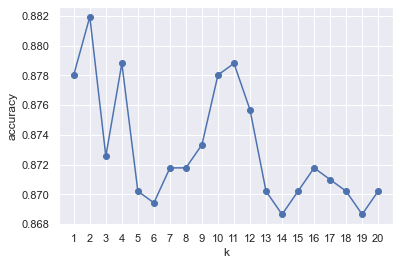

In [12]:
results_mean = {k: np.mean(v) for k, v in results.items()}

plt.plot(list(results_mean.keys()), list(results_mean.values()), 'o-')
plt.xticks(list(results_mean.keys()))
plt.xlabel('k')
plt.ylabel('accuracy')
plt.show()

* O melhor k encontrado é 2

In [13]:
#aplicando padronização ao conjunto de treinamento e teste mas apenas considerando os parametros fitados no treino
scaler = StandardScaler()
scaler.fit(x_train)
x_train_std = scaler.transform(x_train)
x_test_std = scaler.transform(x_test)

clf = KNeighborsClassifier(n_neighbors=2)
clf.fit(x_train_std, y_train)
y_pred = clf.predict(x_test_std)

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print(f'Acurácia: {acc:.3f} | AUC: {auc:.3f}')

Acurácia: 0.897 | AUC: 0.609


#### Árvore de Decisão

In [14]:
clf = DecisionTreeClassifier(random_state=1)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print(f'Acurácia: {acc:.3f} | AUC: {auc:.3f}')

Acurácia: 0.894 | AUC: 0.760


#### Naive Bayes

In [15]:
clf = GaussianNB()
clf.fit(x_train_std, y_train)
y_pred = clf.predict(x_test_std)

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print(f'Acurácia: {acc:.3f} | AUC: {auc:.3f}')

Acurácia: 0.819 | AUC: 0.760


#### SVM

In [16]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

results = {c: [] for c in np.arange(0.5, 10, 0.5)}

for train_index, val_index in skf.split(x_train, y_train):
    
    x_cv_train, x_cv_val = x_train[train_index], x_train[val_index]
    y_cv_train, y_cv_val = y_train[train_index], y_train[val_index]
    
    scaler = StandardScaler()
    scaler.fit(x_cv_train)
    x_cv_train_std = scaler.transform(x_cv_train)
    x_cv_val_std = scaler.transform(x_cv_val)
    
    for c in np.arange(0.5, 10, 0.5):
        
        clf = SVC(C=c, random_state=1)
        clf.fit(x_cv_train_std, y_cv_train)
        y_cv_pred = clf.predict(x_cv_val_std)
        score = accuracy_score(y_cv_val, y_cv_pred)
        results[c].append(score)

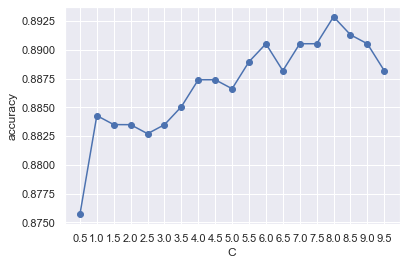

In [17]:
results_mean = {k: np.mean(v) for k, v in results.items()}

plt.plot(list(results_mean.keys()), list(results_mean.values()), 'o-')
plt.xticks(list(results_mean.keys()))
plt.xlabel('C')
plt.ylabel('accuracy')
plt.show()

* O O melhor parâmetro para C é 8

In [18]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_std = scaler.transform(x_train)
x_test_std = scaler.transform(x_test)

clf = SVC(C=8, random_state=1)
clf.fit(x_train_std, y_train)
y_pred = clf.predict(x_test_std)

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print(f'Acurácia: {acc:.3f} | AUC: {auc:.3f}')

Acurácia: 0.900 | AUC: 0.681


#### Random Forest

In [19]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

results = {n: [] for n in range(1, 21)}

for train_index, val_index in skf.split(x_train, y_train):
    
    x_cv_train, x_cv_val = x_train[train_index], x_train[val_index]
    y_cv_train, y_cv_val = y_train[train_index], y_train[val_index]
    
    for n in range(1, 21):
        
        clf = RandomForestClassifier(n_estimators=n, random_state=1)
        clf.fit(x_cv_train, y_cv_train)
        y_cv_pred = clf.predict(x_cv_val)
        score = accuracy_score(y_cv_val, y_cv_pred)
        results[n].append(score)

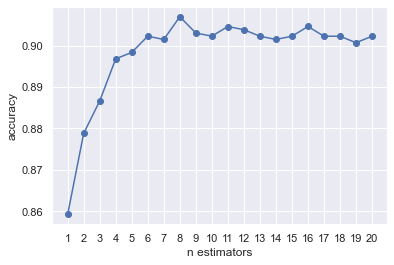

In [20]:
results_mean = {k: np.mean(v) for k, v in results.items()}

plt.plot(list(results_mean.keys()), list(results_mean.values()), 'o-')
plt.xticks(list(results_mean.keys()))
plt.xlabel('n estimators')
plt.ylabel('accuracy')
plt.show()

* Temos 8 como o melhor número de estimadores

In [21]:
clf = RandomForestClassifier(n_estimators=8, random_state=1)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print(f'Acurácia: {acc:.3f} | AUC: {auc:.3f}')

Acurácia: 0.928 | AUC: 0.738


### 3 - Feature Importance

In [22]:
features = np.array(X.columns.to_list())
score = clf.feature_importances_
idx = np.argsort(score)[::-1]

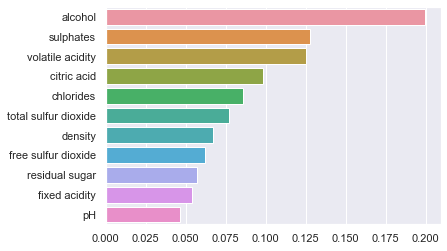

In [23]:
sns.barplot(score[idx], features[idx])
plt.show()

* Alcohol é a variável mais importante para o modelo random forest.
* Para ambas as métricas, o modelo random forest se saiu melhor.